# Import packages

In [47]:
import os
import requests
import networkx as nx
import pandas as pd
import geopandas as gpd
from pyvis.network import Network
import openai
from IPython.display import display, HTML, Code
from IPython.display import clear_output

In [48]:
# %load_ext autoreload
# %autoreload 2

import LLM_Geo_Constants as constants
import helper
# import LLM_Geo_kernel.Solution as Solution

from LLM_Geo_kernel import Solution

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
# Case 4: Hospital_accessibility
# task_name ='Hospital_accessibility'

# TASK = r'''
# For each zipcode area in South Carolina (SC), calculate the distance from the centroid of the zipcode area to its nearest hospital, and then create a choropleth distance map (unit: km), also show the hospital.
# '''

# # TASK = r'Diplay the  zipcode area in South Carolina (SC) and SC hospital locations in a  map.'

# DATA_LOCATIONS = [
# r"SC zipcode boundary shapefile: https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip, the map projection is WGS1984.",
# r"SC hospitals:  https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv, location columns: longitude in 'POINT_X' column, latitude in 'POINT_Y' column.",          
# ]


#Case 2: France_mobility_changes_2020
task_name ='France_mobility_changes_2020'
TASK = r'''
1) Show the 2020 human mobility monthly change rates of each administrative regions in a France map. Each month is a sub-map in a map matrix. The base of the change rate is January 2020. 
2) Draw a line chart to show the monthly change rate trends of all administrative regeions. Each region is a line, the x-axis is 2020 months.
'''

DATA_LOCATIONS = ["ESRI shapefile for France administrative regions:" + \
                  "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip. " + \
                  "The 'GID_1' column is the administrative region code, 'NAME_1' column is the administrative region name.",
                  "REST API url with parameters for human mobility data access:" + \
                  "http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020." + \
                  "The response is in CSV format. There are three columns in the response: " + \
                  "place,date (format:2020-01-07), and intra_movement. 'place' column is the administractive region code of every country; codes for France administrative regions start with 'FRA'.",
                 ]


# Case 3: COVID-19 prevalence trend
# task_name ='COVID_death_rate'
# TASK = r'''1) Draw a map to show the death rate (death/case) of COVID-19 among the countiguous US counties. Use the accumulated COVID-19 data of 2020.12.31 to compute the death rate. Use scheme ='quantiles' when plotting the map.  Set map projection to 'Conus Albers'. Set map size to 15*10 inches.  
# 2) Draw a scatter plot to show the correlation and trend line of the death rate with the senior resident rate, including the r-square and p-value. Set data point transparency to 50%, regression line as red.  Set figure size to 15*10 inches.  
# '''

# DATA_LOCATIONS = [
#                   r"COVID-19 data case in 2020 (county-level): https://github.com/nytimes/covid-19-data/raw/master/us-counties-2020.csv. This data is for daily accumulated COVID cases and deaths for each county in the US. There are 5 columns: date (format: 2021-02-01), county, state, fips, cases, deaths. ",   
#                   r"Contiguous US county boundary (ESRI shapefile): https://github.com/gladcolor/spatial_data/raw/master/contiguous_counties.zip. The county FIPS column is 'GEOID'. ",
#                   r"Census data (ACS2020): https://raw.githubusercontent.com/gladcolor/spatial_data/master/Demography/ACS2020_5year_county.csv. THe needed columns are: 'FIPS', 'Total Population', 'Total Population: 65 to 74 Years', 'Total Population: 75 to 84 Years', 'Total Population: 85 Years and Over'. Drop rows with NaN cells after loading the used columns.",
#                  ]


# Case 4: Hospital_accessibility
# task_name ='Hospital_accessibility'

# TASK = r'''
# For each zipcode area in South Carolina (SC), calculate the distance from the centroid of the zipcode area to its nearest hospital, and then create a choropleth distance map (unit: km), also show the hospital.
# '''

# # TASK = r'Diplay the  zipcode area in South Carolina (SC) and SC hospital locations in a  map.'

# DATA_LOCATIONS = [
# r"SC zipcode boundary shapefile: https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip, the map projection is WGS1984.",
# r"SC hospitals:  https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv, location columns: longitude in 'POINT_X' column, latitude in 'POINT_Y' column.",          
# ]


  
save_dir = os.path.join(os.getcwd(), task_name)
os.makedirs(save_dir, exist_ok=True)

# create graph
# model=r"gpt-3.5-turbo"
model=r"gpt-4"
solution = Solution(
                    task=TASK,
                    task_name=task_name,
                    save_dir=save_dir,
                    data_locations=DATA_LOCATIONS,
                    model=model,
                    )
print("Prompt to get solution graph:\n")
print(solution.direct_request_prompt)

Prompt to get solution graph:

Your role: A professional Geo-information scientist and developer good at Python. 
Your task: Write a Python program to address the question or task: 
1) Show the 2020 human mobility monthly change rates of each administrative regions in a France map. Each month is a sub-map in a map matrix. The base of the change rate is January 2020. 
2) Draw a line chart to show the monthly change rate trends of all administrative regeions. Each region is a line, the x-axis is 2020 months.
 
Location for data you may need: 1. ESRI shapefile for France administrative regions:https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip. The 'GID_1' column is the administrative region code, 'NAME_1' column is the administrative region name.
2. REST API url with parameters for human mobility data access:http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020.The 

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm
import datetime
import seaborn as sns
from io import StringIO

start_date = "01/01/2020"
end_date = "12/31/2020"

# Get the data from URL
shapefile_url = "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip"
gdf_france = gpd.read_file(shapefile_url)

# Download human mobility data
api_mobility_url = f"http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin={start_date}&end={end_date}"
response = requests.get(api_mobility_url)
csv_file = StringIO(response.text)
# Load the data into pandas DataFrame
df_mobility_france = pd.read_csv(csv_file)
# Filter data only for France
df_mobility_france = df_mobility_france[df_mobility_france['place'].str.startswith('FRA')]

# Calculate the monthly human mobility change rate
# Use resample() to calculate the rate
df_mobility_france['date'] = pd.to_datetime(df_mobility_france['date'], format='%Y-%m-%d')
df_mobility_france.set_index('date', inplace=True)
df_mobility_france_monthly = df_mobility_france.groupby('place').resample('M').mean()
df_mobility_france_monthly.reset_index(inplace=True)

# Convert the mobility data into a pivot table
df_mobility_france_pivot = df_mobility_france_monthly.pivot_table(values='intra_movement', index='place', columns='date')
df_mobility_france_pivot = df_mobility_france_pivot.div(df_mobility_france_pivot.iloc[:, 0], axis=0)
df_mobility_france_pivot.reset_index(inplace=True)
df_mobility_france_pivot.columns = [str(col).split('-')[0] + '-' + str(col).split('-')[1] if not isinstance(col, str) else col for col in df_mobility_france_pivot.columns]
df_mobility_france_pivot.drop('2020-01', axis=1, inplace=True)

# Join the mobility data with the shapefile
gdf_france['GID_1'] = gdf_france['GID_1'].astype(str)
df_mobility_france_pivot['place'] = df_mobility_france_pivot['place'].astype(str)

gdf_mobility_france = gdf_france.merge(df_mobility_france_pivot, left_on='GID_1', right_on='place', how='inner')

# Plot the maps of human mobility change rate
n_months = len(df_mobility_france_pivot.columns)-1
n_rows = 3
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 7), sharex=True, sharey=True)
cmap = 'coolwarm'
vmin = 0.5
vmax = 2.0

for i in range(n_months):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    gdf_mobility_france.plot(column=f'2020-{i+2:02d}', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, cax=fig.add_axes([.8, .15, .03, .6]), vmin=vmin, vmax=vmax)
    ax.set_title(f'2020-{i+2:02d}')
    ax.axis('off')

plt.tight_layout()
plt.savefig('monthly_human_mobility_change_fr.png', dpi=300)
plt.show()

# Plot the trend lines
fig, ax = plt.subplots(figsize=(15, 5))
gdf_mobility_france.drop(['geometry', 'NAME_1', 'GID_1'], axis=1).set_index('place').T.plot(cmap=cmap, legend=False, ax=ax)

# Set the x-axis labels
month_labels = [f'2020-{i+2:02d}' for i in range(n_months)]
ax.set_xticks(range(len(month_labels)))
ax.set_xticklabels(month_labels)

ax.set_xlabel('Month')
ax.set_ylabel('Monthly Change Rate')
ax.set_title('Monthly Change Rate Trends of Administrative Regions')
plt.savefig('trend_lines_region_change_rate.png', dpi=300)
plt.show()



-------------- Running code (trial # 1/10) --------------




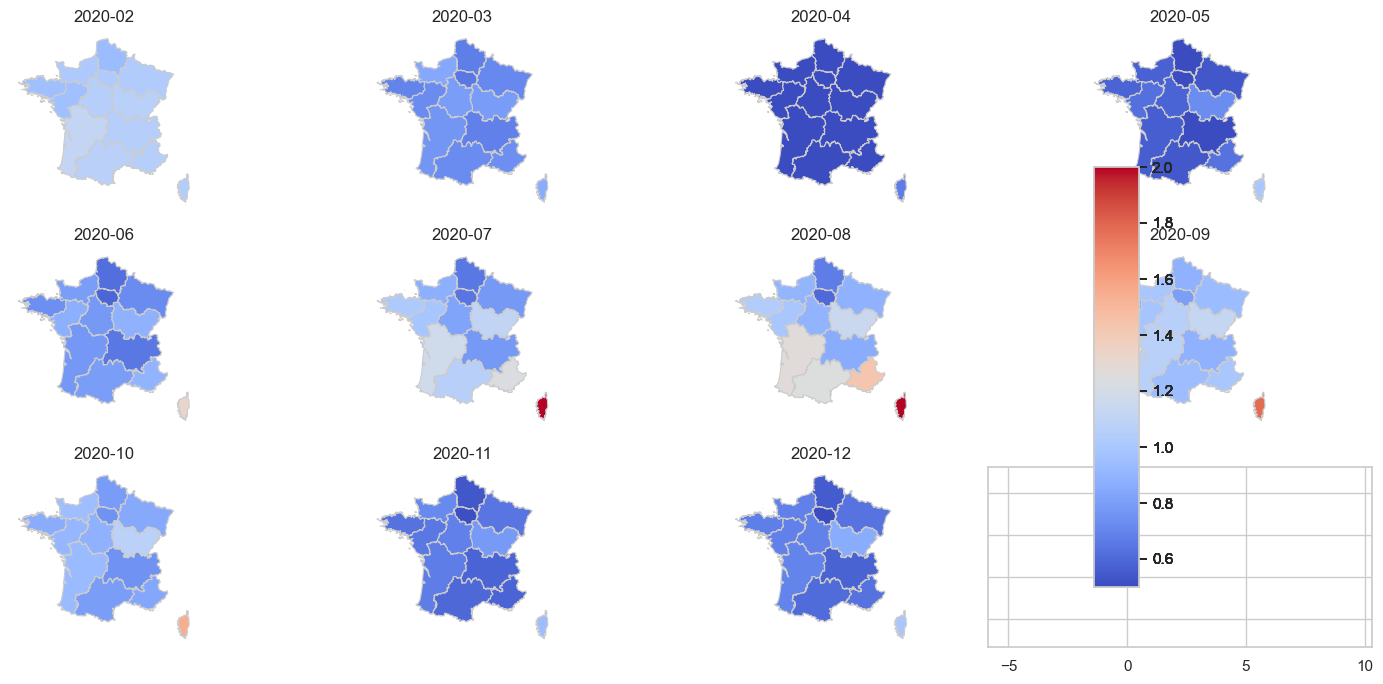

An error occurred:  no numeric data to plot
Sending error information to LLM for debugging...
```python
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm
import datetime
import seaborn as sns
from io import StringIO

start_date = "01/01/2020"
end_date = "12/31/2020"

# Get the data from URL
shapefile_url = "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip"
gdf_france = gpd.read_file(shapefile_url)

# Download human mobility data
api_mobility_url = f"http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin={start_date}&end={end_date}"
response = requests.get(api_mobility_url)
csv_file = StringIO(response.text)
# Load the data into pandas DataFrame
df_mobility_france = pd.read_csv(csv_file)
# Filter data only for France
df_mobility_france = df_mobility_france[df_mobility_france['place'].str.startswith('FRA')]



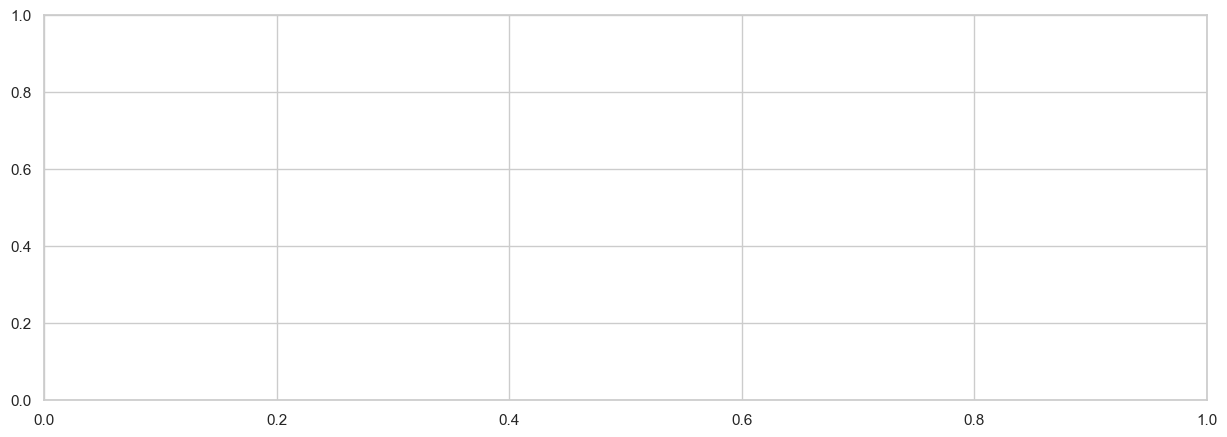

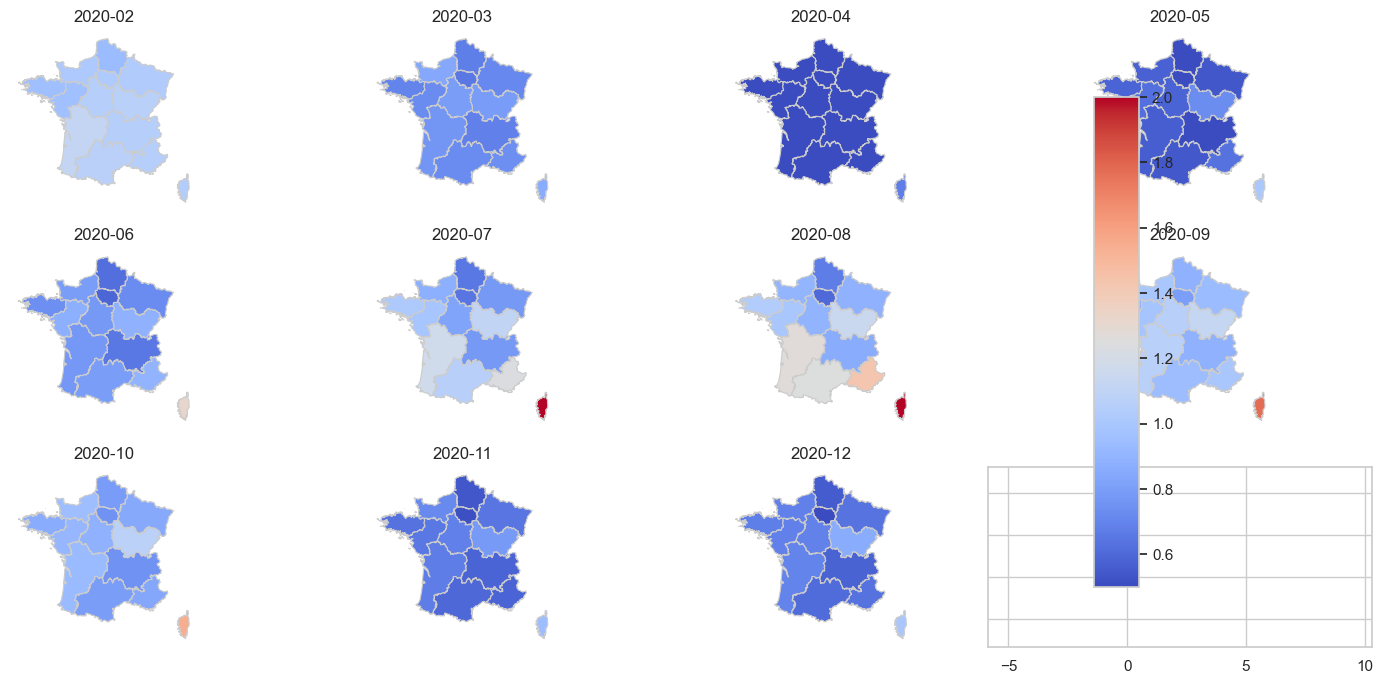

An error occurred:  no numeric data to plot
Sending error information to LLM for debugging...


--- Logging error ---
Traceback (most recent call last):
  File "E:\Research\LLM-Geo\LLM_Geo_kernel.py", line 338, in execute_complete_program
    exec(code)  #
  File "<string>", line 78, in <module>
  File "e:\ProgramData\Anaconda3\envs\street_mapping_env\lib\site-packages\pandas\plotting\_core.py", line 1000, in __call__
    return plot_backend.plot(data, kind=kind, **kwargs)
  File "e:\ProgramData\Anaconda3\envs\street_mapping_env\lib\site-packages\pandas\plotting\_matplotlib\__init__.py", line 71, in plot
    plot_obj.generate()
  File "e:\ProgramData\Anaconda3\envs\street_mapping_env\lib\site-packages\pandas\plotting\_matplotlib\core.py", line 450, in generate
    self._compute_plot_data()
  File "e:\ProgramData\Anaconda3\envs\street_mapping_env\lib\site-packages\pandas\plotting\_matplotlib\core.py", line 635, in _compute_plot_data
    raise TypeError("no numeric data to plot")
TypeError: no numeric data to plot

During handling of the above exception, another exception occurred:

I have reviewed the code and made the necessary changes. The corrected and completed code is:

```python
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm
import datetime
import seaborn as sns
from io import StringIO

start_date = "01/01/2020"
end_date = "12/31/2020"

# Get the data from URL
shapefile_url = "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip"
gdf_france = gpd.read_file(shapefile_url)

# Download human mobility data
api_mobility_url = f"http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin={start_date}&end={end_date}"
response = requests.get(api_mobility_url)
csv_file = StringIO(response.text)
# Load the data into pandas DataFrame
df_mobility_france = pd.read_csv(csv_file)
# Filter data only for France
df_mobility_france = df_mobility_france[df_mobility_france['place'].str.startswith('FRA')]


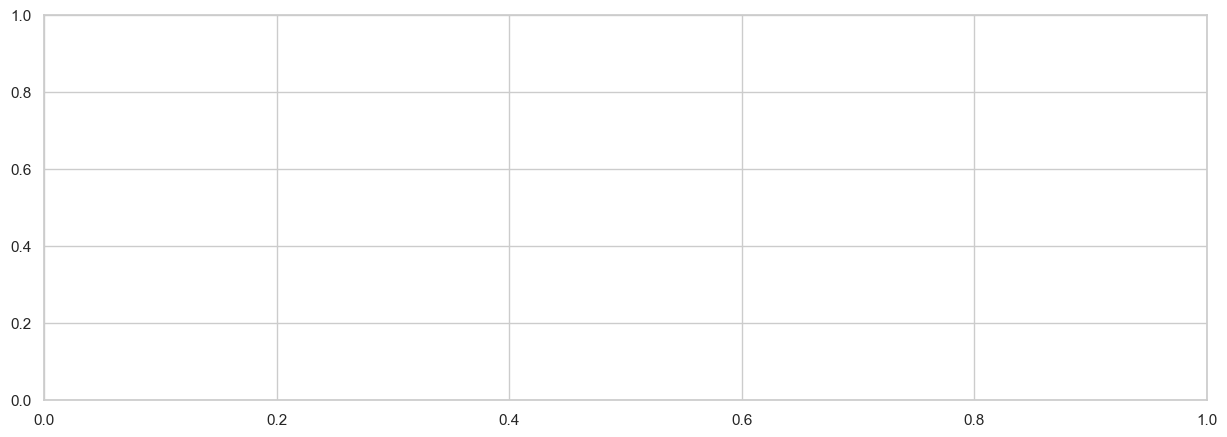

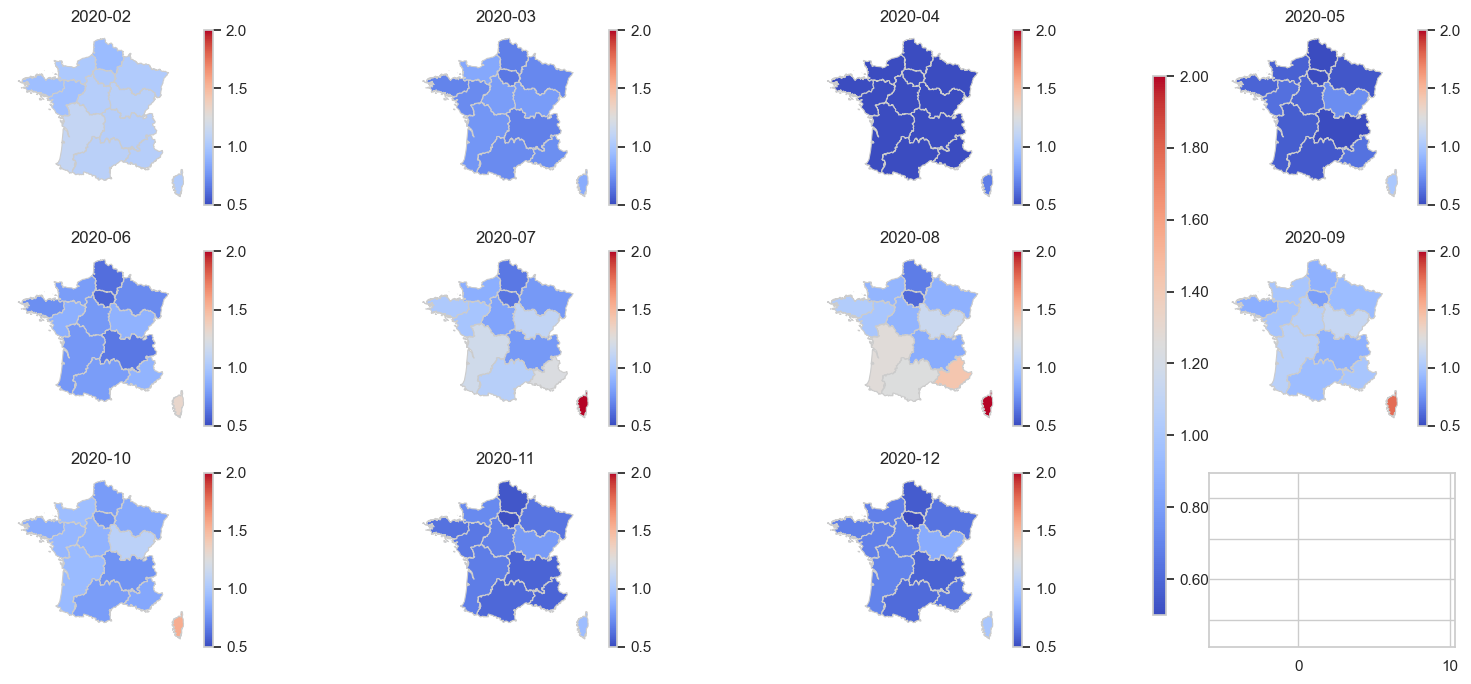

An error occurred:  no numeric data to plot
Sending error information to LLM for debugging...


--- Logging error ---
Traceback (most recent call last):
  File "E:\Research\LLM-Geo\LLM_Geo_kernel.py", line 338, in execute_complete_program
    exec(code)  #
  File "<string>", line 72, in <module>
  File "e:\ProgramData\Anaconda3\envs\street_mapping_env\lib\site-packages\pandas\plotting\_core.py", line 1000, in __call__
    return plot_backend.plot(data, kind=kind, **kwargs)
  File "e:\ProgramData\Anaconda3\envs\street_mapping_env\lib\site-packages\pandas\plotting\_matplotlib\__init__.py", line 71, in plot
    plot_obj.generate()
  File "e:\ProgramData\Anaconda3\envs\street_mapping_env\lib\site-packages\pandas\plotting\_matplotlib\core.py", line 450, in generate
    self._compute_plot_data()
  File "e:\ProgramData\Anaconda3\envs\street_mapping_env\lib\site-packages\pandas\plotting\_matplotlib\core.py", line 635, in _compute_plot_data
    raise TypeError("no numeric data to plot")
TypeError: no numeric data to plot

During handling of the above exception, another exception occurred:

```python
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm
import datetime
import seaborn as sns
from io import StringIO

start_date = "01/01/2020"
end_date = "12/31/2020"

# Get the data from URL
shapefile_url = "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip"
gdf_france = gpd.read_file(shapefile_url)

# Download human mobility data
api_mobility_url = f"http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin={start_date}&end={end_date}"
response = requests.get(api_mobility_url)
csv_file = StringIO(response.text)
# Load the data into pandas DataFrame
df_mobility_france = pd.read_csv(csv_file)
# Filter data only for France
df_mobility_france = df_mobility_france[df_mobility_france['place'].str.startswith('FRA')]

# Calculate the monthly human mobility change rate
# Use resample() to calculate the rate
df_m

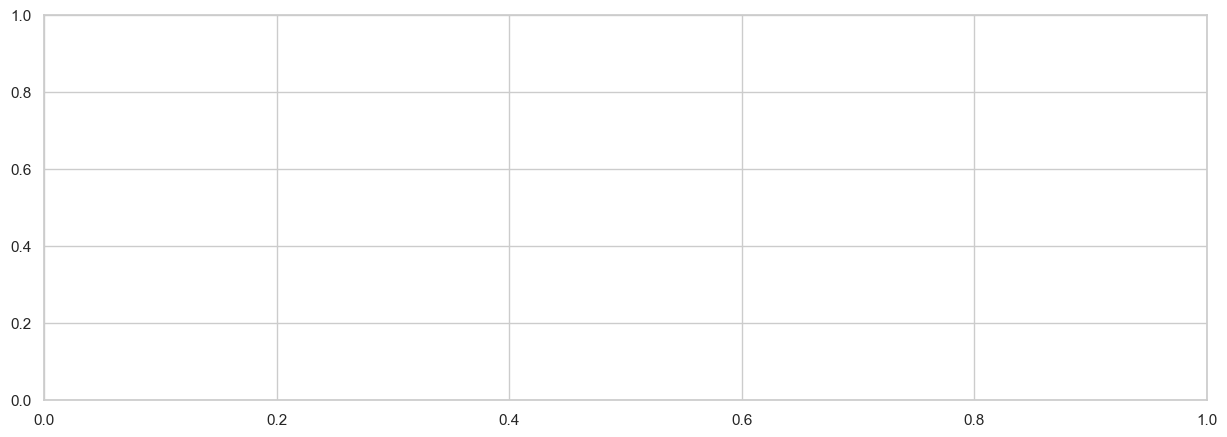

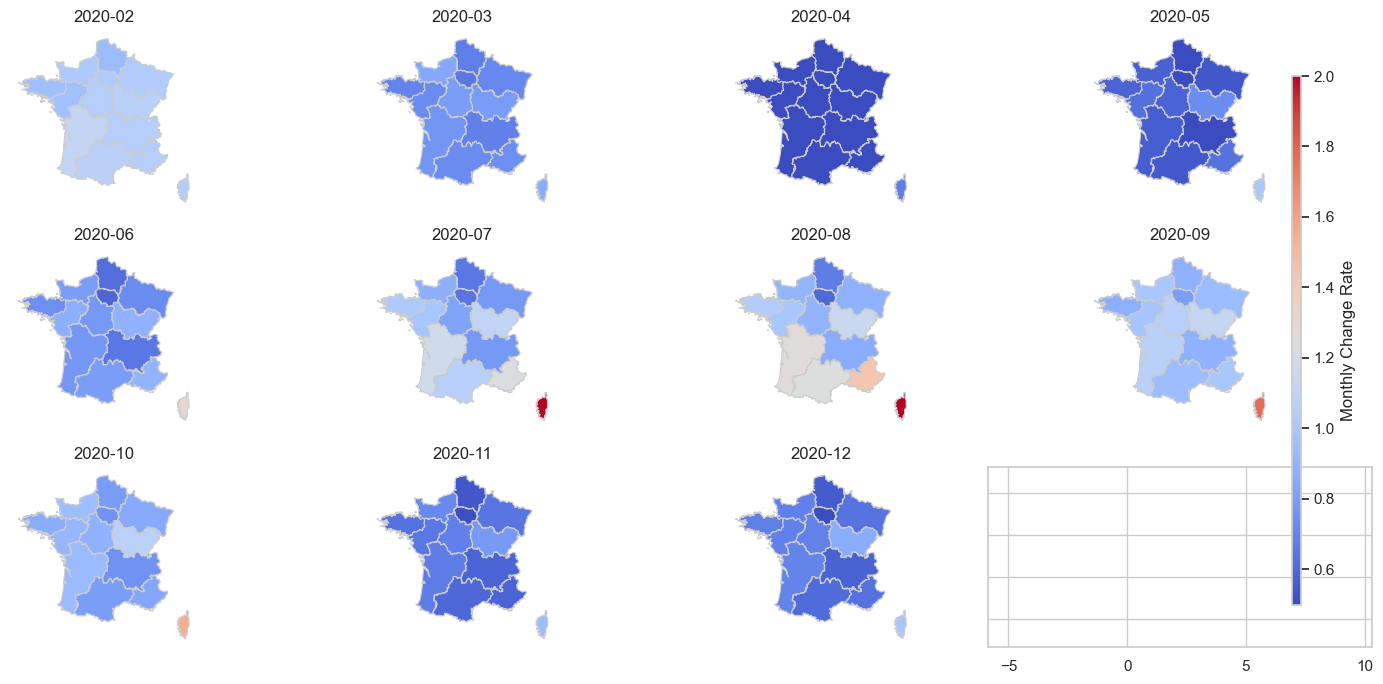

An error occurred:  no numeric data to plot
Sending error information to LLM for debugging...
I have found the issue and corrected the code. The error was caused because of the plotting command in the trend lines plot. To fix the error, I made the following changes:

1. I converted the pivot table data (which is already stored in `df_mobility_france_pivot`) to long format using `pd.melt()`.
2. I also removed the `gdf_mobility_france.drop(['geometry', 'NAME_1', 'GID_1'], axis=1).set_index('place').T.plot(cmap=cmap, legend=False, ax=ax)` command and replaced it with a seaborn lineplot using the long format data.

Here is the corrected and completed code:

```python
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm
import datetime
import seaborn as sns
from io import StringIO

start_date = "01/01/2020"
end_date = "12/31/2020"

# Get the data from URL
shapefile_url = "https://github.com/gladcolor/LLM-Geo/raw

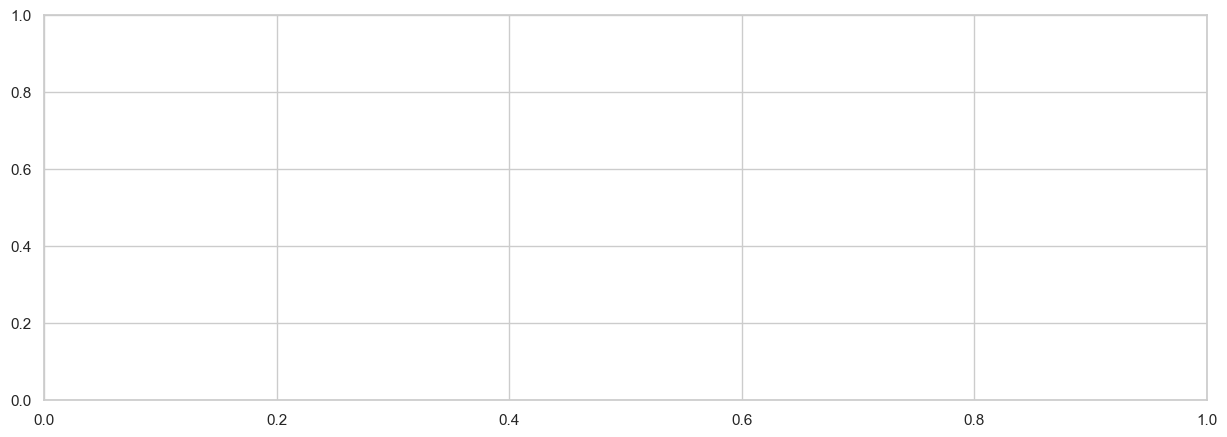

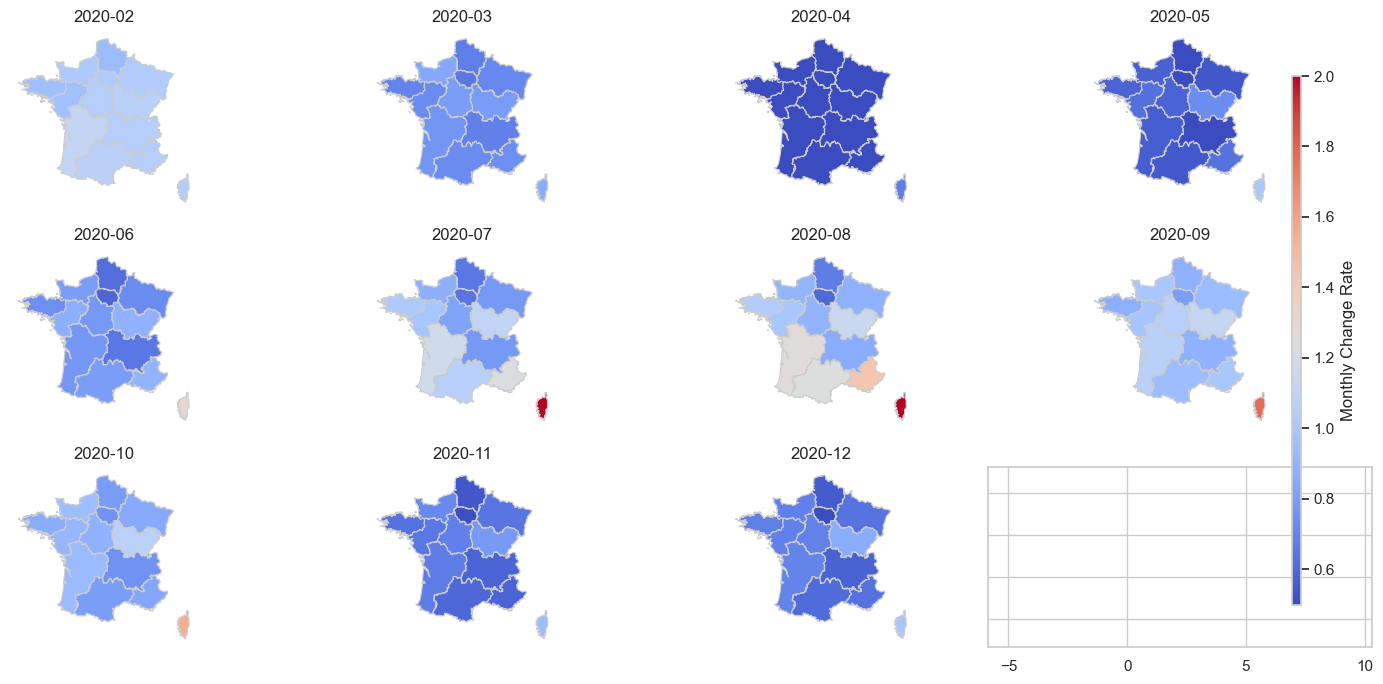

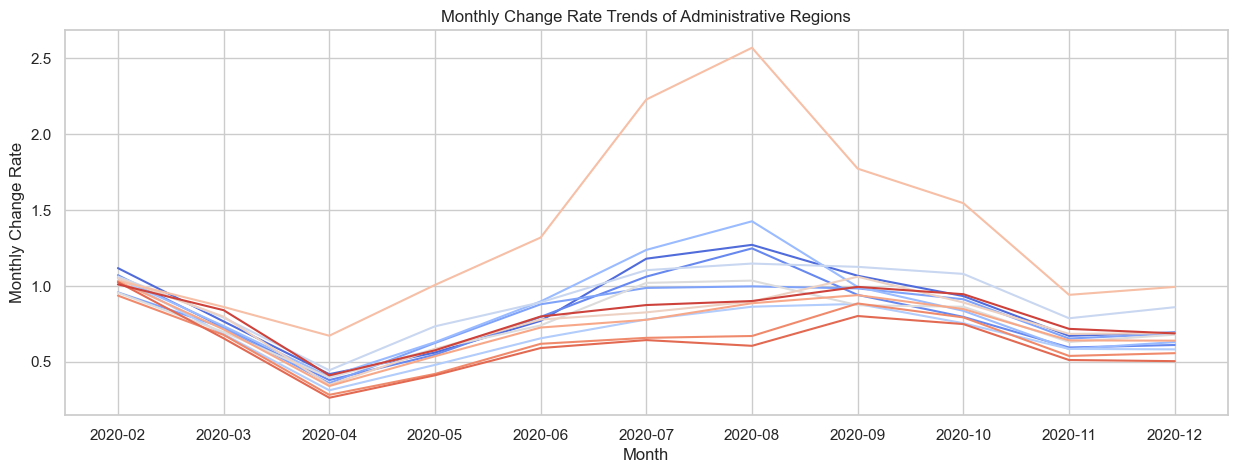



--------------- Done ---------------




import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm
import datetime
import seaborn as sns
from io import StringIO

start_date = "01/01/2020"
end_date = "12/31/2020"

# Get the data from URL
shapefile_url = "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip"
gdf_france = gpd.read_file(shapefile_url)

# Download human mobility data
api_mobility_url = f"http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin={start_date}&end={end_date}"
response = requests.get(api_mobility_url)
csv_file = StringIO(response.text)
# Load the data into pandas DataFrame
df_mobility_france = pd.read_csv(csv_file)
# Filter data only for France
df_mobility_france = df_mobility_france[df_mobility_france['place'].str.startswith('FRA')]

# Calculate the monthly human mobility change rate
# Use resample() to calculate the rate
df_mobility_france['date'] = pd.to_datetime(df_mobility_france['date'], format='%Y-%m-%d')
df_mobility_france.set_index('date', inplace=True)
df_mobility_france_monthly = df_mobility_france.groupby('place')['intra_movement'].resample('M').mean()

# Convert the pd.Series to pd.DataFrame and reset index
df_mobility_france_monthly = df_mobility_france_monthly.to_frame()
df_mobility_france_monthly.reset_index(inplace=True)

# Convert the mobility data into a pivot table
df_mobility_france_pivot = df_mobility_france_monthly.pivot_table(values='intra_movement', index='place', columns='date')
df_mobility_france_pivot = df_mobility_france_pivot.div(df_mobility_france_pivot.iloc[:, 0], axis=0)
df_mobility_france_pivot.reset_index(inplace=True)
df_mobility_france_pivot.columns = [str(col).split('-')[0] + '-' + str(col).split('-')[1] if not isinstance(col, str) else col for col in df_mobility_france_pivot.columns]
df_mobility_france_pivot.drop('2020-01', axis=1, inplace=True)

# Join the mobility data with the shapefile
gdf_france['GID_1'] = gdf_france['GID_1'].astype(str)
df_mobility_france_pivot['place'] = df_mobility_france_pivot['place'].astype(str)

gdf_mobility_france = gdf_france.merge(df_mobility_france_pivot, left_on='GID_1', right_on='place', how='inner')

# Plot the maps of human mobility change rate
n_months = len(df_mobility_france_pivot.columns) - 1
n_rows = 3
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 7), sharex=True, sharey=True)
cmap = 'coolwarm'
vmin = 0.5
vmax = 2.0
cax = fig.add_axes([0.92, 0.125, 0.03, 0.755], aspect=40)
fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin, vmax)), cax=cax, label='Monthly Change Rate')

for i in range(n_months):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    gdf_mobility_france.plot(column=f'2020-{i+2:02d}', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=False, vmin=vmin, vmax=vmax)
    ax.set_title(f'2020-{i+2:02d}')
    ax.axis('off')

plt.tight_layout()
plt.savefig('monthly_human_mobility_change_fr.png', dpi=300, bbox_inches='tight')
plt.show()

# Long-format data for trend lines plot
df_mobility_france_long = pd.melt(df_mobility_france_pivot, id_vars=['place'], var_name='date', value_name='monthly_change_rate')

# Plot the trend lines
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=df_mobility_france_long, x='date', y='monthly_change_rate', hue='place', legend=False, palette=cmap)

# Set the x-axis labels
month_labels = [f'2020-{i+2:02d}' for i in range(n_months)]
ax.set_xticks(range(len(month_labels)))
ax.set_xticklabels(month_labels)

ax.set_xlabel('Month')
ax.set_ylabel('Monthly Change Rate')
ax.set_title('Monthly Change Rate Trends of Administrative Regions')
plt.savefig('trend_lines_region_change_rate.png', dpi=300, bbox_inches='tight')
plt.show()

In [50]:
direct_request_LLM_response = solution.get_direct_request_LLM_response()

clear_output(wait=True)
display(Code(solution.direct_request_code, language='python'))

code = solution.execute_complete_program(code=solution.direct_request_code, try_cnt=10)
# solution.direct_request_code = code
display(Code(code, language='python'))


In [51]:
# def execute_complete_program(self, code: str, try_cnt: int = 10) -> Optional[str]:
#     """
#     Execute a given program, retrying on exceptions.

#     Args:
#         code (str): The code to be executed.
#         try_cnt (int): Maximum number of execution attempts.

#     Returns:
#         Optional[str]: The last executed code or None in case of persistent failure.
#     """
#     count = 0
#     while count < try_cnt:
#         logging.info(f"Running code (trial # {count + 1}/{try_cnt})")
#         try:
#             count += 1
#             exec(code)
#             logging.info("Execution succeeded")
#             return code
#         except Exception as e:
#             logging.error(f"An error occurred: {e}")
#             debug_prompt = self.get_debug_prompt(exception=e, code=self.direct_request_code)
#             logging.info("Sending error information to LLM for debugging")
#             response = helper.get_LLM_reply(prompt=debug_prompt,
#                                             system_role=constants.debug_role,
#                                             model=self.model,
#                                             verbose=True,
#                                             stream=True,
#                                             retry_cnt=3)
#             code = helper.extract_code(response)
#     logging.error("Maximum retry attempts exceeded, rethrowing last exception")
#     raise e  # Rethrow the last exception

In [52]:
# exec(solution.direct_request_code)
# solution.execute_complete_program(try_cnt=10)